# Variation C Leading Indicators

We've deployed Variation C of the Welcome survey to Czech, Korean, and Vietnamese WP. Let's do some quick initial analysis, answering the following questions:

1. What's the proportion of users getting Variation A and Variation C in the two wikis?
2. What number of questions are users responding to?
3. What's the response rate for the two variants?

In [180]:
import json

import datetime as dt
import pandas as pd

from wmfdata import mariadb, hive

from tabulate import tabulate

In [24]:
%load_ext rpy2.ipython

In [60]:
%%R
library(ggplot2);
library(data.table);

/home/nettrom/venv/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: data.table 1.11.8  Latest news: r-datatable.com

  warnings.warn(x, RRuntimeWarning)


# Potential start time change

We decided to change the survey interface by making it not escapable, in other words, users have to click the "skip" button (or some other link) to skip it. This change is scheduled to go in with the SWAT on 2019-01-17. See [T213958](https://phabricator.wikimedia.org/T213958) for more information.

From the Phab task: `[2019-01-17T19:29:25Z] <catrope@deploy1001> Synchronized php-1.33.0-wmf.13/extensions/GrowthExperiments/: Make welcome survey C unescapable`

For now, I've chosen to keep the original start date, and noted that I should make some comparison between user behavior during the first couple of days and what happened right afterwards.

When it comes to the Vietnamese WP, the start date is set based on the following comment from the logs in [T213356](https://phabricator.wikimedia.org/T213356):

`[2019-01-24T19:35:37Z] <jforrester@deploy1001> Synchronized wmf-config/InitialiseSettings.php: SWAT T213356 Enable WelcomeSurvey experiment 2 on viwiki (duration: 00m 53s)`

In [151]:
## Configuration variables

## Czech Wikipedia setup:

## User IDs of known users to exclude (Stephane, Elena, and Marshall's accounts)
cs_known_users = set([322106, 339583, 341191, 341611, 433381, 433382, 433511, 404765, 421667,
                      427625, 437386])

## The start timestamp is the registration timestamp of Roan's test account (which we'll
## filter out later).
cs_start_timestamp = dt.datetime(2019, 1, 15, 0, 42, 44)

cs_end_timestamp = dt.datetime(2019, 2, 5, 0, 0, 0)

## Korean Wikipedia setup:

## User IDs of known users to exclude
ko_known_users = set([384066, 539296, 539299, 539302, 539303, 539304, 539305, 539306, 539307,
                      539298, 416361, 416360, 413162, 495265, 518393, 518394, 518396, 530285,
                      531579, 531785, 536786, 536787, 542720, 542721, 542722, 543192, 543193,
                      544145, 544283])

## Start timestamp is some time prior to the registration timestamp of the first user who
## got the survey. In this case, Roan's timestamp works just fine.
ko_start_timestamp = cs_start_timestamp
ko_end_timestamp = cs_end_timestamp

## Vietnamese Wikipedia setup:

vi_known_users = set()

## For Vietnamese, use the start time from the logs
vi_start_timestamp = dt.datetime(2019, 1, 24, 19, 35, 37)
vi_end_timestamp = cs_end_timestamp

## Format strings:
## MediaWiki database timestamp format
mw_format = "%Y%m%d%H%M%S"
hive_format = "%Y-%m-%dT%H:%M:%S"


In [152]:
## Grab the user IDs of known test accounts so they can be added to the exclusion list

username_patterns = ["MMiller", "Zilant", "Roan", "KHarlan", "MWang", "SBtest"]

known_user_query = '''
SELECT user_id
FROM {wiki}.user
WHERE user_registration >= "{start_timestamp}"
AND user_name LIKE "{name_pattern}%"
'''

for u_pattern in username_patterns:
    cs_known = mariadb.run(known_user_query.format(
        wiki = 'cswiki',
        start_timestamp = cs_start_timestamp.strftime(mw_format),
        name_pattern = u_pattern), fmt = 'raw')
    cs_known_users = cs_known_users | set([r[0] for r in cs_known])

for u_pattern in username_patterns:
    ko_known = mariadb.run(known_user_query.format(
        wiki = 'kowiki',
        start_timestamp = ko_start_timestamp.strftime(mw_format),
        name_pattern = u_pattern), fmt = 'raw')
    ko_known_users = ko_known_users | set([r[0] for r in ko_known])
    
for u_pattern in username_patterns:
    vi_known = mariadb.run(known_user_query.format(
        wiki = 'viwiki',
        start_timestamp = vi_start_timestamp.strftime(mw_format),
        name_pattern = u_pattern), fmt = 'raw')
    vi_known_users = vi_known_users | set([r[0] for r in vi_known])


In [153]:
## Query to retrieve the user ID and whether the registration was on the mobile site
## for all non-autocreated non-app registrations between the given timestamps for the given wiki.

mob_query = '''SELECT event.userid, event.displaymobile
FROM event.serversideaccountcreation
WHERE year = 2019
AND dt BETWEEN "{start_timestamp}" AND "{end_timestamp}"
AND event.isapi = 0
AND event.isselfmade = 1
AND wiki = "{wiki}"
AND event.userid NOT IN ({idlist})
'''

cs_users_raw = hive.run(mob_query.format(
  start_timestamp = cs_start_timestamp.strftime(hive_format),
  end_timestamp = cs_end_timestamp.strftime(hive_format),
  wiki = 'cswiki',
  idlist = ','.join([str(uid) for uid in cs_known_users])))

In [154]:
ko_users_raw = hive.run(mob_query.format(
  start_timestamp = ko_start_timestamp.strftime(hive_format),
  end_timestamp = ko_end_timestamp.strftime(hive_format),
  wiki = 'kowiki',
  idlist = ','.join([str(uid) for uid in ko_known_users])))

In [155]:
vi_users_raw = hive.run(mob_query.format(
  start_timestamp = vi_start_timestamp.strftime(hive_format),
  end_timestamp = vi_end_timestamp.strftime(hive_format),
  wiki = 'viwiki',
  idlist = ','.join([str(uid) for uid in vi_known_users])))

# Group assignment

Groups are randomly assigned with 50% probability to each group, so over time they should end up with that balance. In the meantime, let's keep an eye on it.

In [156]:
## Query adapted from Stephane Bisson

group_assignment_query = '''
SELECT
CASE
    WHEN up_value LIKE "%exp2_target_specialpage%" THEN "A"
    WHEN up_value LIKE "%exp2_target_popup%" THEN "C"
END AS variation,
COUNT(up_user) AS user_count
FROM {wiki}.user_properties
WHERE up_property = 'welcomesurvey-responses'
AND up_value LIKE "%exp2_target_%"
AND up_user IN ({idlist})
GROUP BY variation
'''

cs_groups = mariadb.run(group_assignment_query.format(
    wiki = 'cswiki',
    idlist = ','.join([str(uid) for uid in cs_users_raw['userid']])
))

ko_groups = mariadb.run(group_assignment_query.format(
    wiki = 'kowiki',
    idlist = ','.join([str(uid) for uid in ko_users_raw['userid']])
))

vi_groups = mariadb.run(group_assignment_query.format(
    wiki = 'viwiki',
    idlist = ','.join([str(uid) for uid in vi_users_raw['userid']])
))


In [157]:
cs_groups['percent'] = 100 * cs_groups['user_count'] / cs_groups['user_count'].sum()
cs_groups.round(1)

,variation,user_count,percent
0,A,546,53.8
1,C,468,46.2


In [183]:
## There's one user missing in the user count above. What user ID is that?

user_group_query = '''
SELECT
up_user,
CASE
    WHEN up_value LIKE "%exp2_target_specialpage%" THEN "A"
    WHEN up_value LIKE "%exp2_target_popup%" THEN "C"
END AS variation
FROM {wiki}.user_properties
WHERE up_property = 'welcomesurvey-responses'
AND up_value LIKE "%exp2_target_%"
AND up_user IN ({idlist})
'''

cs_users_groups = mariadb.run(user_group_query.format(
    wiki = 'cswiki',
    idlist = ','.join([str(uid) for uid in cs_users_raw['userid']])
))

In [ ]:
set(cs_users_raw['userid']) - set(cs_users_groups['up_user'])

In [158]:
ko_groups['percent'] = 100 * ko_groups['user_count'] / ko_groups['user_count'].sum()
ko_groups.round(1)

,variation,user_count,percent
0,A,504,50.6
1,C,493,49.4


In [159]:
vi_groups['percent'] = 100 * vi_groups['user_count'] / vi_groups['user_count'].sum()
vi_groups.round(1)

,variation,user_count,percent
0,A,581,52.3
1,C,530,47.7


# Are users answering all questions?

We are concerned that users who see Variation C answer only a few questions, or skip the survey altogether. So, let's calculate the number of questions answered per users and make a histogram. Or two, one for each wiki.

In [160]:
## 1: Grab all the responses
## 2: parse the JSON
## 3: count the number of questions answered per user

## NOTE: we're restricting this to only look at the number of questions answered for users
## who are in the Variation C group.

response_query = '''
SELECT up_user, up_value
FROM {wiki}.user_properties
WHERE up_property = 'welcomesurvey-responses' 
AND up_user IN ({id_list})
AND up_value LIKE "%exp2_target_popup%"
'''

cs_responses = mariadb.run(response_query.format(
    wiki = 'cswiki',
    id_list = ','.join([str(uid) for uid in cs_users_raw['userid']])
))

ko_responses = mariadb.run(response_query.format(
    wiki = 'kowiki',
    id_list = ','.join([str(uid) for uid in ko_users_raw['userid']])
))

vi_responses = mariadb.run(response_query.format(
    wiki = 'viwiki',
    id_list = ','.join([str(uid) for uid in vi_users_raw['userid']])
))


In [161]:
def count_varc_answers(df):
    '''
    Process the survey responses for Variation C found in the given DataFrame `df` and count
    the number of responses for each user. Returns a `pandas.DataFrame` with three columns:
    user ID, how the user reacted (save/skip/abandon), and the number of questions answered.
    
    Note that we never count answers to the question about whether they wanted to be contacted
    by a mentor, as that question is always stored (it's either True or False).
    '''
    
    userids = []
    responses = []
    n_answers = []
    
    for _, row in df.iterrows():
        user_id = row[0]
        response = json.loads(row[1])
        
        userids.append(user_id)
        
        num_answers = 0
        
        if not '_submit_date' in response:
            responses.append('abandon')
            n_answers.append(0)
            continue
        elif '_skip' in response and response['_skip'] == True:
            responses.append('skip')
        else:
            responses.append('save')
            
        ## Did the user answer the "Have you edited Wikipedia before?" question?
        if 'edited' in response and response['edited'] != None:
            num_answers += 1
            
        ## Did the user answer the "Why did you create an account?" question?
        if 'reason' in response and \
            (response['reason'] != None or \
             response['reason'] != '' or \
             response['reason'] != 'placeholder'):
            num_answers += 1
            
        ## Did the user fill out any topics?
        topics = []
        if 'topics' in response:
            topics.extend(response['topics'])

        if 'topics-other-js' in response:
            topics.extend(response['topics-other-js'])
            
        if topics:
            num_answers += 1
    
        n_answers.append(num_answers)

    return(pd.DataFrame(
        {'user_id': userids,
         'response': responses,
         'num_answers': n_answers}))

cs_num_answers = count_varc_answers(cs_responses)
ko_num_answers = count_varc_answers(ko_responses)
vi_num_answers = count_varc_answers(vi_responses)

In [182]:
## Proportion of users who save/skip/abandon

cs_response_types = (cs_num_answers.groupby('response')['num_answers']
                     .count()
                     .reset_index()
                     .rename(columns={'num_answers' : 'n'}))
cs_response_types['percent'] = 100 * cs_response_types['n'] / cs_response_types['n'].sum()
cs_response_types.round(1)

,response,n,percent
0,abandon,63,13.5
1,save,285,60.9
2,skip,120,25.6


In [164]:
## Same but for Korean

ko_response_types = (ko_num_answers.groupby('response')['num_answers']
                     .count()
                     .reset_index()
                     .rename(columns={'num_answers' : 'n'}))
ko_response_types['percent'] = 100 * ko_response_types['n'] / ko_response_types['n'].sum()
ko_response_types.round(1)

,response,n,percent
0,abandon,106,21.5
1,save,241,48.9
2,skip,146,29.6


In [165]:
## Same but for Vietnamese

vi_response_types = (vi_num_answers.groupby('response')['num_answers']
                     .count()
                     .reset_index()
                     .rename(columns={'num_answers' : 'n'}))
vi_response_types['percent'] = 100 * vi_response_types['n'] / vi_response_types['n'].sum()
vi_response_types.round(1)

,response,n,percent
0,abandon,235,44.3
1,save,196,37.0
2,skip,99,18.7


In [166]:
## Grouped by number of answers, for users who didn't skip or abandon:

cs_answers_per_user = (cs_num_answers.loc[cs_num_answers['response'] == 'save']
                       .groupby('num_answers')['response']
                       .count()
                       .reset_index()
                       .rename(columns={'response' : 'n'}))
cs_answers_per_user['percent'] = 100 * cs_answers_per_user['n'] / cs_answers_per_user['n'].sum()
cs_answers_per_user.round(1)

,num_answers,n,percent
0,1,13,4.6
1,2,48,16.8
2,3,224,78.6


In [167]:
## Same, but for Korean:

ko_answers_per_user = (ko_num_answers.loc[ko_num_answers['response'] == 'save']
                       .groupby('num_answers')['response']
                       .count()
                       .reset_index()
                       .rename(columns={'response' : 'n'}))
ko_answers_per_user['percent'] = 100 * ko_answers_per_user['n'] / ko_answers_per_user['n'].sum()
ko_answers_per_user.round(1)

,num_answers,n,percent
0,1,8,3.3
1,2,31,12.9
2,3,202,83.8


In [168]:
## Same, but for Vietnamese:

vi_answers_per_user = (vi_num_answers.loc[vi_num_answers['response'] == 'save']
                       .groupby('num_answers')['response']
                       .count()
                       .reset_index()
                       .rename(columns={'response' : 'n'}))
vi_answers_per_user['percent'] = 100 * vi_answers_per_user['n'] / vi_answers_per_user['n'].sum()
vi_answers_per_user.round(1)

,num_answers,n,percent
0,1,8,4.1
1,2,23,11.7
2,3,165,84.2


/home/nettrom/venv/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


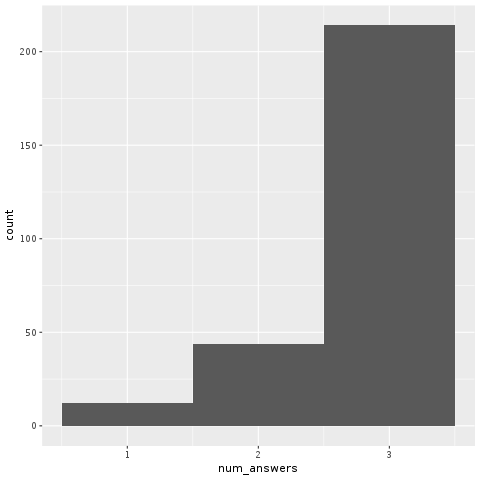

In [86]:
%%R -i cs_num_answers

cs_num_answers = data.table(cs_num_answers);

ggplot(cs_num_answers[response == 'save'], aes(x=num_answers)) +
geom_histogram(binwidth = 1);

## Response rates per variant

In [169]:
## 1: Grab all the responses
## 2: parse the JSON
## 3: figure out what group the user was in, and whether they saved, skipped, or abandoned.

response_query = '''
SELECT up_user, up_value
FROM {wiki}.user_properties
WHERE up_property = 'welcomesurvey-responses' 
AND up_user IN ({id_list})
'''

cs_responses = mariadb.run(response_query.format(
    wiki = 'cswiki',
    id_list = ','.join([str(uid) for uid in cs_users_raw['userid']])
))

ko_responses = mariadb.run(response_query.format(
    wiki = 'kowiki',
    id_list = ','.join([str(uid) for uid in ko_users_raw['userid']])
))

vi_responses = mariadb.run(response_query.format(
    wiki = 'viwiki',
    id_list = ','.join([str(uid) for uid in vi_users_raw['userid']])
))


In [170]:
def process_responses(df):
    '''
    Process the survey responses found in the given DataFrame `df` and determine what group
    the user was in, as well as whether they saved, skipped, or abandoned the survey.
    Returns a `pandas.DataFrame` with three columns:
    user group (A/C), user ID, and how the user reacted (save/skip/abandon)
    '''
    
    groups = []
    userids = []
    responses = []
    
    for _, row in df.iterrows():
        user_id = row[0]
        response = json.loads(row[1])
        
        userids.append(user_id)
        
        if response['_group'] == 'exp2_target_popup':
            groups.append('C')
        elif response['_group'] == 'exp2_target_specialpage':
            groups.append('A')
            
        if not '_submit_date' in response:
            responses.append('abandon')
            continue
        elif '_skip' in response and response['_skip'] == True:
            responses.append('skip')
        else:
            responses.append('save')
            
    return(pd.DataFrame(
        {'group': groups,
         'user_id': userids,
         'response': responses}))

cs_overview = process_responses(cs_responses)
ko_overview = process_responses(ko_responses)
vi_overview = process_responses(vi_responses)

In [171]:
## Grouped by variation and type of response

cs_variation_response = (cs_overview.groupby(['group', 'response'])['user_id']
                         .count()
                         .reset_index()
                         .rename(columns={'user_id' : 'n'}))
cs_variation_response['percent'] = (
    100 * cs_variation_response['n'] /
    cs_variation_response.groupby('group')["n"].transform('sum'))
cs_variation_response.round(1)

,group,response,n,percent
0,A,abandon,120,22.0
1,A,save,380,69.6
2,A,skip,46,8.4
3,C,abandon,63,13.5
4,C,save,285,60.9
5,C,skip,120,25.6


In [172]:
## Same, but for Korean

ko_variation_response = (ko_overview.groupby(['group', 'response'])['user_id']
                         .count()
                         .reset_index()
                         .rename(columns={'user_id' : 'n'}))
ko_variation_response['percent'] = (
    100 * ko_variation_response['n'] /
    ko_variation_response.groupby('group')["n"].transform('sum'))
ko_variation_response.round(1)

,group,response,n,percent
0,A,abandon,150,29.8
1,A,save,314,62.3
2,A,skip,40,7.9
3,C,abandon,106,21.5
4,C,save,241,48.9
5,C,skip,146,29.6


In [173]:
## Same but for Vietnamese

vi_variation_response = (vi_overview.groupby(['group', 'response'])['user_id']
                         .count()
                         .reset_index()
                         .rename(columns={'user_id' : 'n'}))
vi_variation_response['percent'] = (
    100 * vi_variation_response['n'] /
    vi_variation_response.groupby('group')["n"].transform('sum'))
vi_variation_response.round(1)

,group,response,n,percent
0,A,abandon,267,46.0
1,A,save,283,48.7
2,A,skip,31,5.3
3,C,abandon,235,44.3
4,C,save,196,37.0
5,C,skip,99,18.7


## Split by mobile/desktop

We join the responses with information about whether the user signed up on the desktop or mobile site and investigate if the trends are the same.

In [176]:
## Grouped by desktop/mobile, variation, and type of response.

cs_variation_response_split = (pd.merge(cs_overview, cs_users_raw,
                                        left_on='user_id', right_on='userid')
                               .groupby(['displaymobile', 'group', 'response'])['user_id']
                               .count()
                               .reset_index()
                               .rename(columns={'user_id' : 'n'}))
cs_variation_response_split['percent'] = (
    100 * cs_variation_response_split['n'] /
    cs_variation_response_split.groupby(['displaymobile', 'group'])["n"].transform('sum'))
cs_variation_response_split.round(1)

,displaymobile,group,response,n,percent
0,False,A,abandon,96,23.2
1,False,A,save,284,68.8
2,False,A,skip,33,8.0
3,False,C,abandon,38,11.2
4,False,C,save,233,68.9
5,False,C,skip,67,19.8
6,True,A,abandon,24,18.0
7,True,A,save,96,72.2
8,True,A,skip,13,9.8
9,True,C,abandon,25,19.2


In [177]:
## Same, but for Korean

ko_variation_response_split = (pd.merge(ko_overview, ko_users_raw,
                                        left_on='user_id', right_on='userid')
                               .groupby(['displaymobile', 'group', 'response'])['user_id']
                               .count()
                               .reset_index()
                               .rename(columns={'user_id' : 'n'}))
ko_variation_response_split['percent'] = (
    100 * ko_variation_response_split['n'] /
    ko_variation_response_split.groupby(['displaymobile', 'group'])["n"].transform('sum'))
ko_variation_response_split.round(1)

,displaymobile,group,response,n,percent
0,False,A,abandon,104,30.6
1,False,A,save,212,62.4
2,False,A,skip,24,7.1
3,False,C,abandon,65,19.2
4,False,C,save,181,53.6
5,False,C,skip,92,27.2
6,True,A,abandon,46,28.0
7,True,A,save,102,62.2
8,True,A,skip,16,9.8
9,True,C,abandon,41,26.5


In [179]:
## Same, but for Vietnamese

vi_variation_response_split = (pd.merge(vi_overview, vi_users_raw,
                                        left_on='user_id', right_on='userid')
                               .groupby(['displaymobile', 'group', 'response'])['user_id']
                               .count()
                               .reset_index()
                               .rename(columns={'user_id' : 'n'}))
vi_variation_response_split['percent'] = (
    100 * vi_variation_response_split['n'] /
    vi_variation_response_split.groupby(['displaymobile', 'group'])["n"].transform('sum'))
vi_variation_response_split.round(1)

,displaymobile,group,response,n,percent
0,False,A,abandon,236,57.8
1,False,A,save,161,39.5
2,False,A,skip,11,2.7
3,False,C,abandon,210,56.1
4,False,C,save,122,32.6
5,False,C,skip,42,11.2
6,True,A,abandon,31,17.9
7,True,A,save,122,70.5
8,True,A,skip,20,11.6
9,True,C,abandon,25,16.0
